In [1]:
# basic imports
import numpy as np
import sys,os,h5py,math
import matplotlib.pyplot as plt
from argparse import Namespace

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import pytorch_lightning as pl

# Personal imports
sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
from lib.metrics import accuracy,weighted_aucs

chpt_path = None

## DanQ

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        
    def __len__(self): return len(self.x)

    def __getitem__(self, i): return self.x[i].long(), self.y[i].float()

In [3]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.model = models.DanQ()
        self.bs = bs #batch size
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {}#{'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat, y)}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {}#{'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y_pred = F.softmax(y_hat,dim=1).detach().cpu()
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        trn_ds = CustomDataset(X_train,y_train)
        trn_dl = DataLoader(trn_ds, batch_size=self.bs,shuffle=True, num_workers=6)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = CustomDataset(X_valid,y_valid)
        vld_dl = DataLoader(vld_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        test = np.load('../data/Processed/test.npz')
        X_test = torch.tensor(test['arr_0'][:])
        y_test = torch.tensor(test['arr_1'][:])
                              
        tst_ds = CustomDataset(X_test,y_test)
        tst_dl = DataLoader(tst_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return tst_dl

In [4]:
exp = Experiment(bs=512)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data',log_gpu_memory='min_max')    
trainer.fit(exp) 
# #trainer.test()

Loading training dataset


Validation sanity check:   0%|          | 0/5 [00:00<?, ?batch/s]

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
exp = Experiment(bs=512)
chpt_path = '../data/lightning_logs/version_4/checkpoints/_ckpt_epoch_1.ckpt'
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
# exp.cuda()
trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.1,val_percent_check=0.5,
                     test_percent_check=0.1, default_save_path='../data',log_gpu_memory='min_max')
trainer.test(exp)

## Transformer XL

In [ ]:
import transformers as ts

In [ ]:
class LMDataset(Dataset):
    def __init__(self,x,y,mem_len):
        super(LMDataset,self).__init__()
        self.x, self.y = x,y
        self.n = x.shape[0]*math.ceil(1000/mem_len)
        
    def __len__(self): return self.n
    def __getitem__(self, i): 
        (b_idx,seq_idxs, seq_start) = i
        x = self.x[b_idx,seq_idxs[0]:seq_idxs[1]].long()
        inp,tgt = x[:-1], x[1:]
        return inp,tgt,seq_start
    
class LMSampleR(Sampler):
    def __init__(self, ds, bs,mem_len):
        self.ds, self.bs = ds, bs
        self.mem_len = mem_len
        
    def __len__(self): return len(self.ds)
    
    def __iter__(self):
        for i in range(0,self.ds.x.shape[0],self.bs):
            for j in range(0,1000,self.mem_len):
                seq_idxs = (j,j+self.mem_len+1)
                for k in range(self.bs):
                    b_idx = i+k
                    seq_start = j==0 
                    yield (b_idx,seq_idxs, seq_start) # (bs,seq_len)

In [ ]:
class TransXL_LM(nn.Module):
    def __init__(self,cfg):
        super(TransXL_LM, self).__init__()
        self.cfg = cfg
        self.core = ts.TransfoXLModel(cfg)
        self.lm_head = nn.Linear(self.cfg.d_model,self.cfg.vocab_size)
        
    def forward(self,x,mems=None):
        last_hidden_state,  mems = self.core(x,mems)
        out = self.lm_head(last_hidden_state)
        return out, mems

In [ ]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.cfg = ts.TransfoXLConfig(vocab_size=4, d_model=64, d_embed=8, n_head=4, d_head=16, d_inner=128, 
                             n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )
        self.model = TransXL_LM(self.cfg)
        self.bs = bs #batch size
        self.loss_fn = nn.CrossEntropyLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

#     def test_step(self, batch, batch_idx):
#         x, y, new_mem = batch
#         self.mem = None if new_mem[0] else self.mem
#         y_hat, self.mem = self.forward(x)
#         y_pred = F.softmax(y_hat,dim=1).detach().cpu()
#         return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

#     def test_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         y_preds = torch.cat([x['y_pred'] for x in outputs])
#         y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
#         roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        
        trn_ds = LMDataset(X_train,y_train,self.cfg.mem_len)
        splr   = LMSampleR(trn_ds,self.bs,self.cfg.mem_len)
        trn_dl = DataLoader(trn_ds, self.bs,sampler=splr,pin_memory=True)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = LMDataset(X_valid,y_valid,self.cfg.mem_len)
        splr   = LMSampleR(vld_ds,self.bs,self.cfg.mem_len)
        vld_dl = DataLoader(vld_ds,self.bs,sampler=splr,pin_memory=True)
        return vld_dl
    
#     @pl.data_loader
#     def test_dataloader(self):
#         test = np.load('../data/Processed/test.npz')
#         X_test = torch.tensor(test['arr_0'][:])
#         y_test = torch.tensor(test['arr_1'][:])
                              
#         tst_ds = LMDataset(X_test,y_test,self.cfg.mem_len)
#         splr   = LMSampleR(tst_ds,self.bs,self.cfg.mem_len)
#         tst_dl = DataLoader(tst_ds,self.bs,sampler=splr,pin_memory=True)
#         return tst_dl

In [ ]:
exp = Experiment(bs=32)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data')    

trainer.fit(exp)

In [ ]:
#add acc
#dataloader slow when num_workers>0
#add shuffler to samplers
#apex https://github.com/adityaiitb/pyprof2
#resnet+transformerxl

## Resnet + TransformerXL

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        
    def __len__(self): return len(self.x)

    def __getitem__(self, i): return self.x[i].long(), self.y[i].float()

In [3]:
# cyclic lr with restart
def lr_i(step_i,cycle_len = 1000, lrs = (3e-4,1e-5),warm_pct = 4/20):
    cycle_i = step_i%cycle_len
    warm_len = int(cycle_len*warm_pct)
    cool_len = cycle_len - warm_len
    lr_range = lrs[0]-lrs[1]
    
    if cycle_i < warm_len:
        return lrs[1] + lr_range*(cycle_i/warm_len)
    else:
        return lrs[0] - lr_range*((cycle_i-warm_len)/cool_len)
    
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,50*30,10000)
# y = list(map(lr_i,x))
# plt.figure(figsize=(20,10))
# plt.ylim([0,4e-4])
# plt.scatter(x,y)

In [4]:
# https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters,bottom = -0.0001, top=0.001):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             print(n)
            mean = p.grad.abs().mean()
#             if mean.item() == 0: print(n)
            ave_grads.append(mean)
            max_grads.append(p.grad.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    return fig

In [5]:
def plot_weight_mag(named_parameters,bottom = -0.001, top=1.5):
    '''Plots the weight magnitude through different layers in the net during training.'''
    ave_wgts = []
    max_wgts = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_wgts.append(p.abs().mean())
            max_wgts.append(p.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_wgts)), max_wgts, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_wgts)), ave_wgts, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_wgts)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_wgts), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_wgts))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average weight")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-weight', 'mean-weight', 'zero-weight'])
    return fig

In [6]:
class Experiment(pl.LightningModule):

    def __init__(self,model,hparams):
        super(Experiment, self).__init__()
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
        self.bs = hparams.train['bs']
        self.lr = hparams.optim['lr']
        self.hparams = hparams
        
    def forward(self, x): return self.model(x)

    def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
        # warm up lr
        if self.trainer.global_step < 500:
            lr_scale = min(1., float(self.trainer.global_step + 1) / 200.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.lr

#         for pg in optimizer.param_groups:
#             pg['lr'] = lr_i(self.trainer.global_step) 
        idx = batch_idx-self.hparams.train['batch_acum']+1
        if idx%5000==0:
            self.logger.experiment.add_figure('Gradients',plot_grad_flow(self.model.named_parameters()),idx)
            with torch.no_grad():
                self.logger.experiment.add_figure('Weights',plot_weight_mag(self.model.named_parameters()),idx)
            
        optimizer.step()
        optimizer.zero_grad()
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'val_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()

        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        tensorboard_logs = {'val_loss': avg_loss,'valid_roc_auc':roc_auc,'valid_pr_auc':pr_auc,'valid_acc':acc}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def test_end(self, outputs,save_preds=True):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        if save_preds: self.preds=[y_preds,y_trues]
            
        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        print('Test ROC AUC:',roc_auc.item(),'Test PR AUC:',pr_auc.item())
        tensorboard_logs = {'test_loss': avg_loss,'test_roc_auc':roc_auc,'test_pr_auc':pr_auc,'test_acc':acc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return eval(self.hparams.optim_name)(self.parameters(), **self.hparams.optim)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        
        trn_ds = CustomDataset(X_train,y_train)
        trn_dl = DataLoader(trn_ds, self.bs,pin_memory=True,shuffle=True)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = CustomDataset(X_valid,y_valid)
        vld_dl = DataLoader(vld_ds,self.bs,pin_memory=True)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        test = np.load('../data/Processed/test.npz')
        X_test = torch.tensor(test['arr_0'][:])
        y_test = torch.tensor(test['arr_1'][:])
                              
        tst_ds = CustomDataset(X_test,y_test)
        tst_dl = DataLoader(tst_ds,self.bs,pin_memory=True)
        return tst_dl

In [7]:
#lstm
hparams = {'emb': {'vocab_size':4, 'd_emb':64},
           'resnet': {'n_res_blocks':3, 'res_k':32, 'res_p':0.01},
           'seq_model_name': 'BiLSTM', 
           'seq_model': {'d_model':352,'p':0.01},
           'lin': {'skip_cnt':True, 'fc_h_dim':512, 'lin_p':0.01},
           'train': {'bs':25, 'batch_acum':4},
           'optim_name':'torch.optim.AdamW',
           'optim':{'lr':1e-4,'betas':(0.5,0.999),'weight_decay':0}
          }
# chpt_path = '../data/lightning_logs/version_19/checkpoints/_ckpt_epoch_8.ckpt'

In [7]:
#BERT
# hparams = {'emb': {'vocab_size':4, 'd_emb':64},
#            'resnet': {'n_res_blocks':3, 'res_k':16, 'res_p':0.1},
#            'seq_model_name': 'BERT', 
#            'seq_model': {'d_model':256, 'n_layer':4, 'n_head':4},
#            'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.05},
#            'train': {'bs':25, 'batch_acum':4},
#            'optim_name':'torch.optim.Adam',
#            'optim':{'lr':1e-4,'betas':(0.5,0.999)}
#           }

In [8]:
#t_xl model
# hparams = {'emb': {'vocab_size':4, 'd_emb':64},
#            'resnet': {'n_res_blocks':3, 'res_k':16},
#            'seq_model_name': 'TransXL', 
#            'seq_model': {'d_model':352, 'n_layer':6, 'n_head':4, 'd_head':16, 'd_inner':256},
#            'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.5, 'WVN':True},
#            'train': {'bs':25, 'batch_acum':4},
#            'optim_name':'torch.optim.Adam',
#            'optim':{'lr':1e-4,'betas':(0.5,0.999)}
#           }

In [ ]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])

model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])
model.summary()
hparams = Namespace(**hparams)

exp = Experiment(model,hparams)

if chpt_path:
    exp.load_state_dict(torch.load(chpt_path)['state_dict'])

trainer = pl.Trainer(gpus=1, fast_dev_run=False, max_nb_epochs=10, accumulate_grad_batches=hparams.train['batch_acum'],
                     train_percent_check=1, val_check_interval=0.05, use_amp=seq_model.use_amp,
                     default_save_path='../data')    
trainer.fit(exp)

Model parameters:				
Resnet part:	33297k
Sequence part:	2076k
Linear part:	45528k
Total:		81030k
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading training dataset


Epoch 1:   8%|▊         | 15310/182400 [27:39<4:48:09,  9.66batch/s, batch_nb=14988, gpu=0, loss=0.075, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  10%|▉         | 17801/182400 [32:23<5:24:42,  8.45batch/s, batch_nb=17480, gpu=0, loss=0.075, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  11%|█▏        | 20697/182400 [37:47<5:14:30,  8.57batch/s, batch_nb=20056, gpu=0, loss=0.074, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  12%|█▏        | 22725/182400 [41:52<4:41:03,  9.47batch/s, batch_nb=22084, gpu=0, loss=0.072, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  14%|█▎        | 24985/182400 [46:18<5:02:58,  8.66batch/s, batch_nb=24344, gpu=0, loss=0.074, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  15%|█▌        | 27949/182400 [51:35<4:52:41,  8.79batch/s, batch_nb=26988, gpu=0, loss=0.072, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  17%|█▋        | 30185/182400 [56:05<4:59:48,  8.46batch/s, batch_nb=29224, gpu=0, loss=0.072, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  18%|█▊        | 32945/182400 [1:01:37<4:50:20,  8.58batch/s, batch_nb=31984, gpu=0, loss=0.071, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  19%|█▉        | 35261/182400 [1:06:15<5:05:57,  8.02batch/s, batch_nb=34300, gpu=0, loss=0.073, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  21%|██▏       | 39053/182400 [1:13:26<4:57:03,  8.04batch/s, batch_nb=37772, gpu=0, loss=0.070, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  23%|██▎       | 41385/182400 [1:17:58<4:17:08,  9.14batch/s, batch_nb=40104, gpu=0, loss=0.070, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  24%|██▍       | 43661/182400 [1:22:21<4:02:02,  9.55batch/s, batch_nb=42380, gpu=0, loss=0.069, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  25%|██▌       | 46421/182400 [1:27:11<3:59:35,  9.46batch/s, batch_nb=44820, gpu=0, loss=0.069, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  28%|██▊       | 50437/182400 [1:34:47<3:58:53,  9.21batch/s, batch_nb=48836, gpu=0, loss=0.069, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  29%|██▉       | 52485/182400 [1:38:40<3:59:20,  9.05batch/s, batch_nb=50884, gpu=0, loss=0.070, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  30%|██▉       | 53833/182400 [1:41:17<3:59:35,  8.94batch/s, batch_nb=52232, gpu=0, loss=0.071, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  31%|███       | 56873/182400 [1:46:43<4:00:27,  8.70batch/s, batch_nb=54952, gpu=0, loss=0.069, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  33%|███▎      | 60561/182400 [1:53:52<3:39:38,  9.25batch/s, batch_nb=58640, gpu=0, loss=0.070, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  34%|███▍      | 62681/182400 [1:58:03<3:41:29,  9.01batch/s, batch_nb=60760, gpu=0, loss=0.069, v_nb=26]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  36%|███▌      | 65849/182400 [2:03:58<3:38:40,  8.88batch/s, batch_nb=63608, gpu=0, loss=0.070, v_nb=26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  36%|███▋      | 66183/182400 [2:04:39<3:58:13,  8.13batch/s, batch_nb=63941, gpu=0, loss=0.069, v_nb=26]

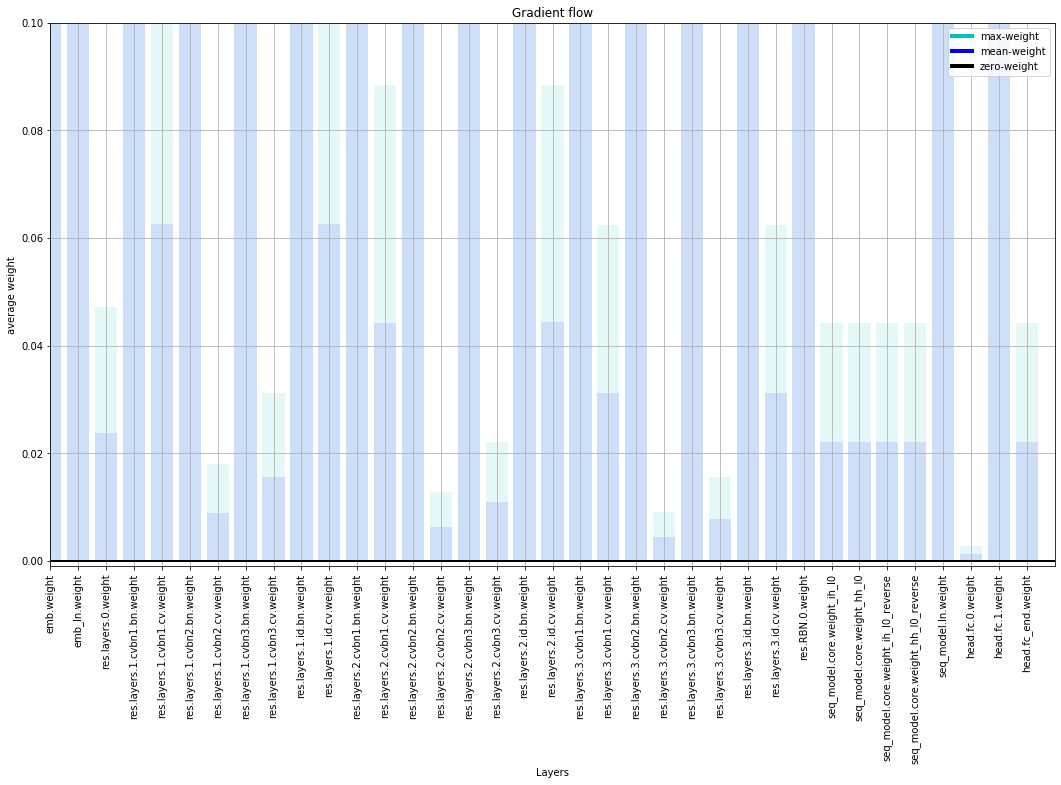

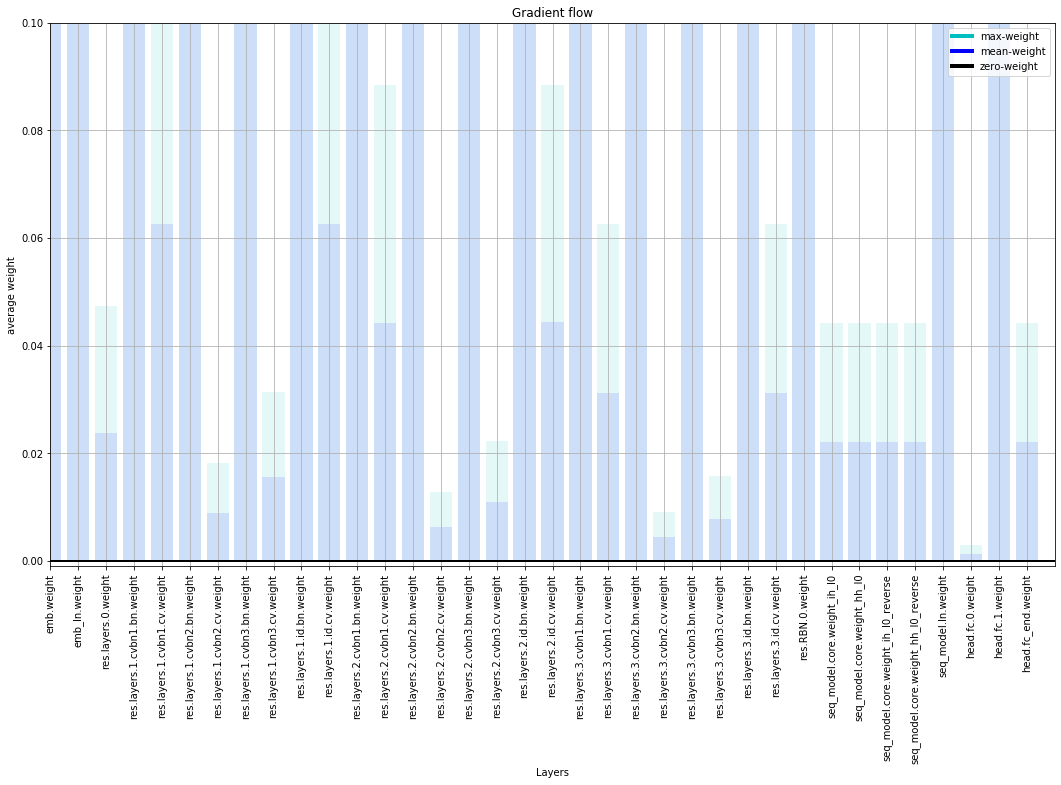

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
op = torch.optim.Adam(model.parameters(), lr=1e-4,betas=(0.5,0.999))
# plt.figure(figsize=(20,15))
for i,(x,y) in enumerate(exp.val_dataloader()[0]):
    op.zero_grad()
    x,y = x.cuda(),  y.cuda()
    y_hat, mem = model(x)
    loss = loss_fn(y_hat, y)
    loss.backward()
#     fig = plot_grad_flow(model.named_parameters())
    fig = plot_weight_mag(model.named_parameters(),bottom = -0.001, top=1.5)
    op.step()
    if i==1:break

In [ ]:
# TODO
# find memory leak(loading train dataset on every run)
# torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
# label smoothing
# balanced valdiation
# plot weights and activations with tensorbaord 

## Validation

In [12]:
trainer.test(exp)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading training dataset


Testing: 100%|██████████| 18201/18201 [03:42<00:00, 81.95batch/s]

Test ROC AUC: 0.895789623260498 Test PR AUC: 0.43330907821655273


In [ ]:
#TODO

# https://arxiv.org/pdf/1912.01857.pdf
# https://github.com/feidfoe/AdjustBnd4Imbalance/blob/master/cifar.py
gamma = 0.1 # hparams for re_scaling https://arxiv.org/pdf/1912.01857.pdf
if args.evaluate:
    print('\nEvaluation only')
    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/o RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))

    current_state = model.state_dict()
    W = current_state['module.fc.weight']

    imb_factor = 1. / args.imbalance
    img_max = 50000/num_classes
    num_sample = [img_max * (imb_factor**(i/(num_classes - 1))) \
                     for i in range(num_classes)]

    ns = [ float(n) / max(num_sample) for n in num_sample ]
    ns = [ n**gamma for n in ns ]
    ns = torch.FloatTensor(ns).unsqueeze(-1).cuda()
    new_W = W / ns

    current_state['module.fc.weight'] = new_W
    model.load_state_dict(current_state)

    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/  RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))